# GANs - Redes Neuronales Adversarias - Caso aplicado
## Trabajo Semana 8
## Asignatura: Computer vision
### Especialización en Inteligencia Artificial
### Integrantes grupo 12:
###### Jorge Armando Serrano Duque
###### Daniel Cadavid Zuleta
###### Oscar Yesid Cárdenas Santos
###### Saúl Andrés Garnica Gutiérrez
###### Michael Andrés Mora Poveda

## Objetivo:

La idea principal de este notebook es crear, compilar y ejecutar una red neuronal adversaria para un dataset de imágenes, en nuestro caso, tomaremos el dataset de MNIST y utilizaremos el framework Tensorflow.


1. Importamos las librerías correspondientes para nuestra red neuronal y para gráficos:


In [14]:
# Importamos las librerías correspondientes:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import initializers
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.layers import  Dropout
from tensorflow.keras.layers import LeakyReLU
import numpy as np
from tensorflow.keras.datasets import mnist
import random
import glob
import imageio
import os
import PIL
import time
from IPython import display
from sklearn.utils import shuffle



2. Del módulo de datasets de tensorflow.keras importamos nuestro dataset de 70.000 imágenes y definimos nuestros conjuntos de entrenamiento y testing junto a la respectiva normalización.

Posteriormente, visualizamos algunas imágenes:

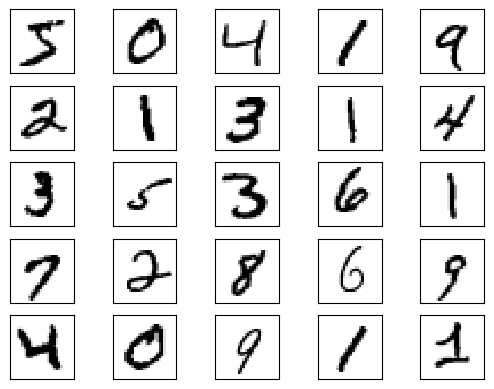

In [15]:
# load the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# normalize our inputs to be in the range[-1, 1]
X_train = (X_train.astype(np.float32) - 127.5)/127.5

# convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have 784 columns per row
X_train = X_train.reshape(60000, 784)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(X_train.shape[0], 28, 28)[i], interpolation='nearest', cmap='gray_r')

5. Definimos la red neuronal adversaria con las siguientes funciones:

* **Función get_optimizer()**: Se instancia el optimizador Adam
* **Función get_generator()**: Crear una red neuronal completamente conectada y secuencial con un kernel_initializer que genera una distribución aleatoria uniforme para la red neuronal asociada al Generador G. Además, se instancian funciones de activación LeakyReLU() y tanh(). Luego imprime el summary de toda la arquitectura.
* **Función get_discriminator(optimizer)**: Crea la arquitectura asociada al discriminador D. Toma como argumento el parámetro optimizer igual a Adam.
* **Función get_gan_network(discriminator, random_dim, generator, optimizer)**: Toma como argumentos las redes neuronales de D y G, el optimizador Adam y el vector de números aleatorios random_dim.
* **Función train(X_train, y_train, x_test, y_test, epochs=10, minibatch_size=128, random_dim = 100)**: Toma como argumentos los datasets de training y testing, para correr la GAN con 10 epochs y lotes de 128 imágenes. Dicha función genera dos archivos de extensión h5 para las redes neuronales asociadas al Generador y Discriminador.
* **Función plot_generated_images()**: Genera un panel de imágenes resultantes del Generador.


In [16]:
def get_optimizer():
  adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)

  return adam

def get_generator(optimizer, random_dim):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer = 'uniform', bias_initializer = 'zeros'))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    generator.summary()
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer = 'uniform', bias_initializer = 'zeros'))
    discriminator.add(LeakyReLU(alpha=0.3))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(alpha=0.3))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(alpha=0.3))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    discriminator.summary()
    return discriminator

def get_gan_network(discriminator, random_dim, generator, optimizer):

    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False

    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))

    # the output of the generator (an image)
    x = generator(gan_input)

    # get the output of the discriminator (probability of the image being real or not)
    gan_output = discriminator(x)

    gan = Model(inputs=gan_input, outputs=gan_output) # inputs and outputs under keras version 2.2.2
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)

    gan.summary()
    return gan

# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, random_dim, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

def train(X_train, y_train, x_test, y_test, epochs=10, minibatch_size=128, random_dim = 100):

# Build our GAN network
    adam = get_optimizer()
    G = get_generator(adam, random_dim)
    D = get_discriminator(adam)
    gan = get_gan_network(D, random_dim, G, adam)

    # for plotting at the end
    D_loss = []
    G_loss = []

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)

        # Defines a cost related to an epoch
        epoch_cost = 0.


        # get number of minibatch based on size of data
        num_minibatches = int(X_train.shape[0] / minibatch_size)

        # Randomize data point
        X_train, y_train = shuffle(X_train, y_train)


        # Split the training data into batches of size 128
        for i in range(0, X_train.shape[0], minibatch_size):
            #print(i)

            # Get pair of (X, y) of the current minibatch
            X_train_mini = X_train[i:i + minibatch_size]
            y_train_mini = y_train[i:i + minibatch_size]


            ##### Train discriminator #####
            # Get a set of legit images from MNIST data
            legit_images = X_train_mini[np.random.randint(0, X_train_mini.shape[0], size=int(minibatch_size/2))]

            # Get a set of fake images generated from noise
            noise = np.random.normal(0, 1, size=[int(minibatch_size/2), random_dim]) # random_dim = 100 here
            syntetic_images = G.predict(noise)


            # create 1 dataset with both legit (1) and generated (0) images
            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((int(minibatch_size/2), 1)), np.zeros((int(minibatch_size/2), 1))))
            y_combined_batch[:int(minibatch_size/2)] = 0.9 # only for real images

            # Train discriminator
            D.trainable = True
            d_loss = D.train_on_batch(x_combined_batch, y_combined_batch)
            D_loss.append(d_loss)


            ###### Train generator #####
            noise = np.random.normal(0, 1, size=[minibatch_size, random_dim])
            y_gen = np.ones(minibatch_size)
            D.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)
            G_loss.append(g_loss)


        print ("Cost of D after epoch %i: %f" % (e, d_loss))
        print ("Cost of G after epoch %i: %f" % (e, g_loss))



        if e == 1 or e % 20 == 0:
             plot_generated_images(e, G, random_dim)

    # Save models in case (creates a HDF5 file 'model.h5')
    G.save_weights('Generator.h5')
    D.save_weights('Discriminator.h5')

    return [D_loss, G_loss]


In [ ]:
if __name__ == '__main__':
    [D_loss, G_loss] = train(X_train, y_train, X_test, y_test, epochs = 10, minibatch_size=128, random_dim = 100)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_35 (Dense)            (None, 784)              

A continuación vemos los resultados por epoch para el Discriminador y el Generador:

| Epoch | Cost - Discriminador D | Cost - Generador G |
|-------|------------------------|--------------------|
| 1     | 0.443434               | 2.217913           |
| 2     | 0.478006               | 2.208592           |
| 3     | 0.388643               | 2.359263           |
| 4     | 0.439400               | 1.775148           |
| 5     | 0.459723               | 2.485619           |
| 6     | 0.404798               | 1.783805           |
| 7     | 0.486127               | 2.000782           |
| 8     | 0.463650               | 1.753741           |


Para las dos últimas epochs el kernel falla en su ejecución.

De acuerdo a los resultados, se realizan las siguientes observaciones:

*  Para el Discriminador D representa qué tan bien está distinguiendo entre las imágenes reales y las generadas. Un valor bajo del loss function indica que el discriminador D está teniendo éxito en su tarea.

* Para el valor asociado al loss function del Generador G representa qué tan bien el generador está engañando al discriminador. Un valor bajo de esta pérdida indica que el generador está produciendo imágenes que son capaces de engañar al discriminador y parecen más reales.

En general, vemos que el modelo necesita aumentar las épocas de entrenamiento y ampliar y modificar capas convolucionales junto a otros hiperpárametros. Asimismo, aumentar la capacidad de cómputo es vital para obtener mejores resultados.

### Referencias:

1. Generative Adversarial Networks and Some of GAN Applications: Everything You Need to Know. Barla, N. (2023). Neptune.ai. Retrieved from: https://neptune.ai/blog/generative-adversarial-networks-gan-applications

2. Deep Convolutional Generative Adversarial Network. Tensorflow Webpage API. (2023). Tensorflow. Retrieved from: https://www.tensorflow.org/tutorials/generative/dcgan
